In [3]:
import ssl
import urllib.request
import urllib.parse
from typing import Optional


def disable_ssl_verification():
    """
    Globally disable SSL certificate verification for urllib requests.
    
    This function modifies the default SSL context to bypass certificate
    verification issues commonly encountered on macOS when accessing
    UCI ML Repository datasets.
    
    Note: This reduces security by disabling certificate verification.
    Use only for trusted sources like UCI ML Repository.
    
    Returns:
        None
    """
    try:
        # Create an unverified SSL context
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE
        
        # Create a custom HTTPS handler with unverified SSL context
        https_handler = urllib.request.HTTPSHandler(context=ssl_context)
        
        # Install the custom handler globally
        opener = urllib.request.build_opener(https_handler)
        urllib.request.install_opener(opener)
        
        print("✅ SSL certificate verification disabled globally")
        print("🔒 Warning: This reduces security - use only for trusted sources")
        
    except Exception as e:
        print(f"❌ Failed to disable SSL verification: {e}")
        raise


def enable_ssl_verification():
    """
    Re-enable SSL certificate verification by restoring default settings.
    
    This function restores the default SSL context and HTTPS handler,
    re-enabling certificate verification for security.
    
    Returns:
        None
    """
    try:
        # Create default SSL context (with verification)
        ssl_context = ssl.create_default_context()
        
        # Create default HTTPS handler
        https_handler = urllib.request.HTTPSHandler(context=ssl_context)
        
        # Install the default handler
        opener = urllib.request.build_opener(https_handler)
        urllib.request.install_opener(opener)
        
        print("✅ SSL certificate verification re-enabled")
        
    except Exception as e:
        print(f"❌ Failed to re-enable SSL verification: {e}")
        raise


def fetch_with_ssl_bypass(name: Optional[str] = None, id: Optional[int] = None):
    """
    Fetch UCI ML Repository dataset with automatic SSL bypass.
    
    This function temporarily disables SSL verification, fetches the dataset,
    then re-enables SSL verification for security.
    
    Parameters:
        name (str, optional): Dataset name or substring
        id (int, optional): Dataset ID
        
    Returns:
        Dataset object from ucimlrepo
        
    Example:
        from ssl_validation import fetch_with_ssl_bypass
        data = fetch_with_ssl_bypass(name='Iris')
    """
    from ucimlrepo import fetch_ucirepo
    
    # Store original state
    original_ssl_context = ssl.create_default_context()
    
    try:
        # Temporarily disable SSL verification
        disable_ssl_verification()
        
        # Fetch the dataset
        if name and id:
            raise ValueError('Only specify either dataset name or ID, not both')
        elif name:
            data = fetch_ucirepo(name=name)
        elif id:
            data = fetch_ucirepo(id=id)
        else:
            raise ValueError('Must provide either dataset name or ID')
            
        print(f"✅ Successfully fetched dataset")
        return data
        
    finally:
        # Always re-enable SSL verification for security
        enable_ssl_verification()


def configure_pandas_ssl():
    """
    Configure pandas to work with SSL certificate issues.
    
    This function sets up pandas to handle HTTPS URLs with SSL certificate
    verification disabled, which is specifically useful for reading CSV files
    from UCI ML Repository.
    
    Returns:
        None
    """
    try:
        # Import pandas to configure its URL handling
        import pandas as pd
        
        # Create unverified SSL context
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE
        
        # Monkey patch pandas' URL opener to use unverified SSL
        original_urlopen = urllib.request.urlopen
        
        def patched_urlopen(url, *args, **kwargs):
            if isinstance(url, str) and url.startswith('https://'):
                kwargs['context'] = ssl_context
            return original_urlopen(url, *args, **kwargs)
        
        urllib.request.urlopen = patched_urlopen
        
        print("✅ Pandas SSL configuration applied")
        
    except Exception as e:
        print(f"❌ Failed to configure pandas SSL: {e}")
        raise


# Convenience function for common use case
def setup_uci_ssl_bypass():
    """
    One-time setup function to configure SSL bypass for UCI ML Repository.
    
    Call this once at the beginning of your script to enable seamless
    access to UCI ML Repository datasets without SSL certificate issues.
    
    Example:
        from ssl_validation import setup_uci_ssl_bypass
        setup_uci_ssl_bypass()
        
        # Now you can use fetch_ucirepo normally
        from ucimlrepo import fetch_ucirepo
        data = fetch_ucirepo(name='Iris')
    """
    print("🔧 Setting up UCI ML Repository SSL bypass...")
    disable_ssl_verification()
    configure_pandas_ssl()
    print("🎉 Setup complete! UCI ML Repository should now work without SSL issues")


if __name__ == "__main__":
    # Test the SSL bypass functionality
    print("Testing SSL validation bypass...")
    
    try:
        setup_uci_ssl_bypass()
        
        # Test fetch_ucirepo
        from ucimlrepo import fetch_ucirepo
        data = fetch_ucirepo(name='Iris')
        
        print(f"✅ Test successful! Dataset shape: {data.data.features.shape}")
        
    except Exception as e:
        print(f"❌ Test failed: {e}")
    
    finally:
        # Re-enable SSL for security
        enable_ssl_verification()
        print("🔒 SSL verification re-enabled for security")

Testing SSL validation bypass...
🔧 Setting up UCI ML Repository SSL bypass...
✅ SSL certificate verification disabled globally
🔒 Warning: This reduces security - use only for trusted sources
✅ Pandas SSL configuration applied
🎉 Setup complete! UCI ML Repository should now work without SSL issues
✅ Test successful! Dataset shape: (150, 4)
✅ SSL certificate verification re-enabled
🔒 SSL verification re-enabled for security


In [4]:
# Call this once at the beginning of your script
disable_ssl_verification()

# Now fetch_ucirepo will work without SSL certificate issues
from ucimlrepo import fetch_ucirepo, list_available_datasets
list_available_datasets()

✅ SSL certificate verification disabled globally
🔒 Warning: This reduces security - use only for trusted sources
-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale

In [ ]:
# special import for the adult dataset
from ucimlrepo import fetch_ucirepo, list_available_datasets
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

y                    <=50K    <=50K.      >50K     >50K.
workclass                                               
?                 0.066545  0.000000  0.024359  0.000000
Federal-gov       0.023827  0.024424  0.047315  0.050371
Local-gov         0.059709  0.063485  0.078689  0.082185
Never-worked      0.000283  0.000260  0.000000  0.000000
Private           0.717354  0.760956  0.632955  0.642630
Self-emp-inc      0.019984  0.022778  0.079327  0.083775
Self-emp-not-inc  0.073503  0.083839  0.092335  0.093584
State-gov         0.038228  0.043825  0.045020  0.046925
Without-pay       0.000566  0.000433  0.000000  0.000530
y                <=50K    <=50K.      >50K     >50K.
education                                           
10th          0.035235  0.034660  0.007907  0.006500
11th          0.045105  0.048653  0.007652  0.008320
12th          0.016181  0.016807  0.004209  0.003900
1st-4th       0.006553  0.006192  0.000765  0.000520
5th-6th       0.012824  0.013269  0.002041  0.002860
7t

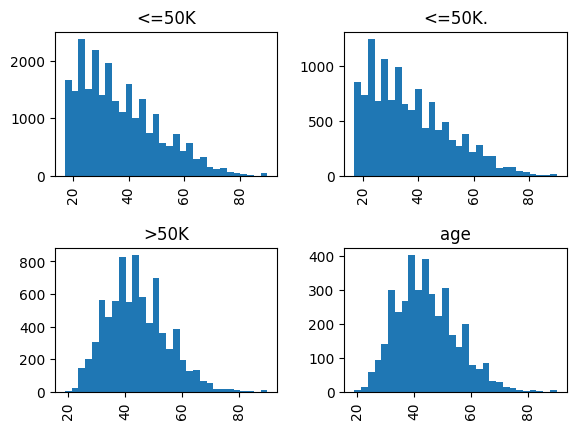

fnlwgt


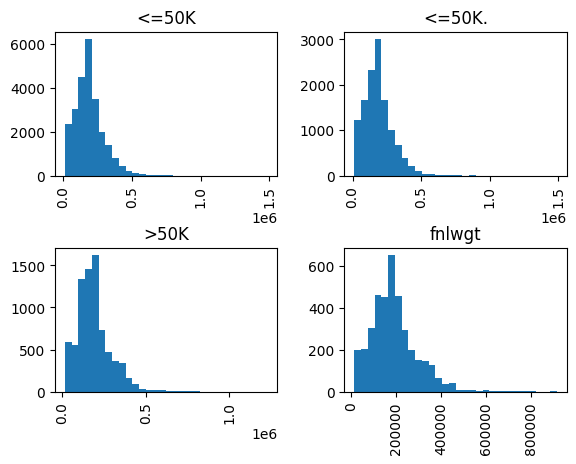

education-num


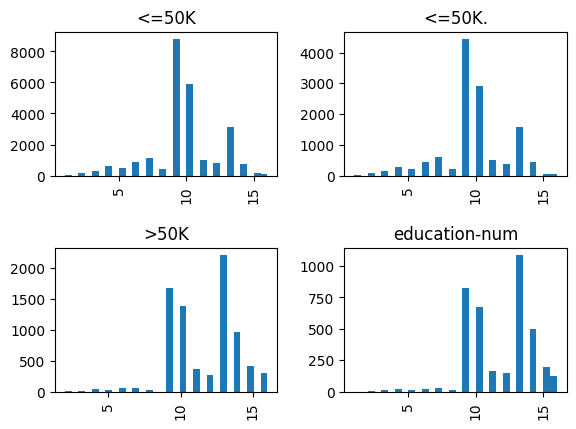

capital-gain


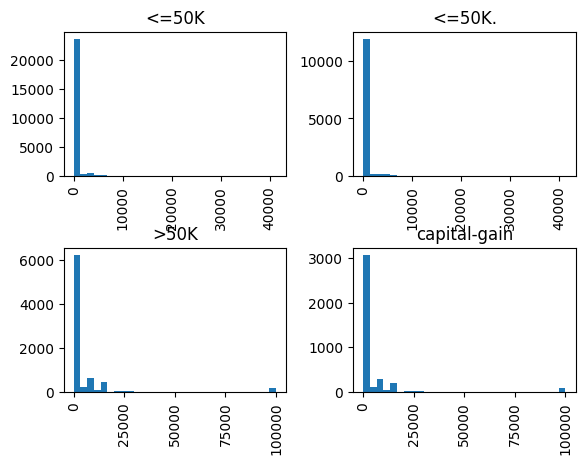

capital-loss


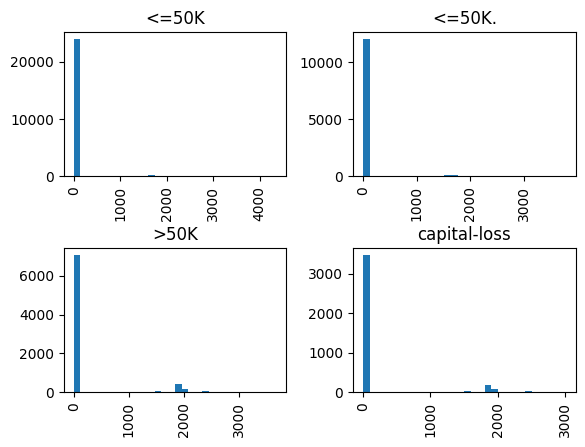

hours-per-week


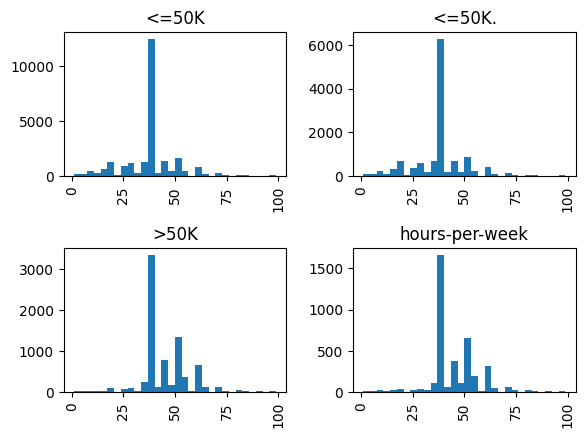

In [21]:
# cell 07
data = adult.data.features
data['y'] = adult.data.targets

for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        print(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.title(column)
    plt.show()

                     age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.076628       0.030940      0.077229      0.056944   
fnlwgt         -0.076628  1.000000      -0.038761     -0.003706     -0.004366   
education-num   0.030940 -0.038761       1.000000      0.125146      0.080972   
capital-gain    0.077229 -0.003706       0.125146      1.000000     -0.031441   
capital-loss    0.056944 -0.004366       0.080972     -0.031441      1.000000   
hours-per-week  0.071558 -0.013519       0.143689      0.082157      0.054467   

                hours-per-week  
age                   0.071558  
fnlwgt               -0.013519  
education-num         0.143689  
capital-gain          0.082157  
capital-loss          0.054467  
hours-per-week        1.000000  


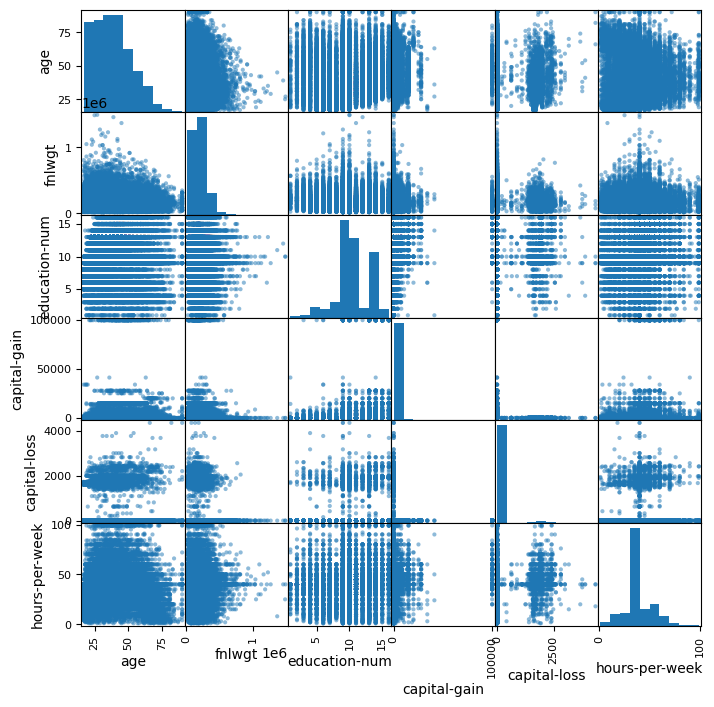

In [23]:
# cell 08
print(data.corr(numeric_only=True))
pd.plotting.scatter_matrix(data, figsize=(8, 8))
plt.show()